# ECE 285 IVR Assignment 6 - Wiener Deconvolution

## Arik Horodniceanu A53285765

In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.assignment6 as im
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Spectral Deconvolution

### 1.1 Part I (mean power spectral density)

### 1

In [38]:
def average_power_spectral_density(x):
    n1,n2 = x.shape[1:3]
    K = x.shape[0]
    apsd = np.zeros(x[0].shape)
    for idx in range(K):
        apsd += np.abs(npf.fft2(x[idx],axes=(0, 1)))**2
    apsd = np.mean(apsd, axis=2)
    return apsd/K

### 2

<IPython.core.display.Javascript object>


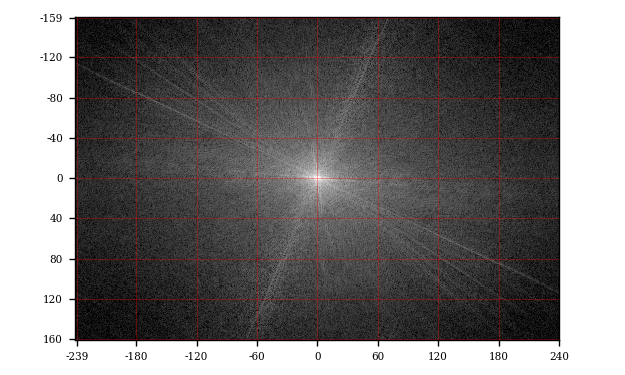

In [76]:
x1 = plt.imread('assets/eagle.png')
x2 = plt.imread('assets/plane.png')
x3 = plt.imread('assets/sheeps.png')
x = [x1, x2, x3]
x = np.array(x)
res = average_power_spectral_density(x)
im.showfft(res,apply_log=True, vmin=-10, vmax=5)

### 3

From equation (2), it is given that for $\large{\omega_{u,v} \neq 0: S_{u,v} = n_1n_2e^{\beta}\omega_{u,v}^{\alpha}.}$  

Taking the logarithm and using logarithm rules we get: 

$\large{logS_{u,v} = logn_1 + logn_2 + \beta + \alpha log(\omega_{u,v}) = logn_1 + logn_2 + \beta + \alpha t_{u,v} \rightarrow}$

$\large{s_{u,v} = logS_{u,v} - logn_1 - logn_2. \square}$

### 4

To ease the notation, denote $D = \{0\le u<n_1, 0\le v<n_2, (u,v)\neq(0,0)\}.$ Note that $\sum_D = n_1n_2 - 1 > 0.$

So: $\large{SSE(\alpha,\beta) = \frac{1}{2} \sum_D (\alpha t_{u,v} + \beta - s_{u,v}^{(avg)})^2.}$ Taking the derivative with respect to the parameters $\alpha, \beta$ we get:

$\large{\frac{dSSE}{d\beta} = \sum_D  (\alpha t_{u,v} + \beta - s_{u,v}^{(avg)}) = 0 \rightarrow}$ 

$\large{\beta^* = \frac{\sum_D (s_{u,v}^{(avg)} - \alpha t_{u,v})}{\sum_D}=\frac{\sum_D (s_{u,v}^{(avg)}-\alpha t_{u,v})}{n_1n_2 -1}.}$

$\large{\frac{d^2SSE}{d\beta^2} = \sum_D = n_1n_2 - 1 > 0}.$ , so indeed $\beta^*$ is a minimum.

Next: $\large{\frac{dSSE}{d\alpha} = \sum_D t_{u,v}(\alpha t_{u,v} + \beta - s_{u,v}^{(avg)}) = 0 \rightarrow \alpha^* = \frac{\sum_D t_{u,v}(s_{u,v}^{(avg)} - \beta)}{\sum_D t_{u,v}^2}.}$

Plugging in the value of $\beta^*$ we got, the result is:

$\Large{\alpha^* = \frac{\sum_D s_{u,v}^{(avg)}t_{(u,v)} - \frac{\sum_Ds_{u,v}^{(avg)}\sum_D t_{u,v}}{n_1n_2 - 1}}{\sum_D t_{u,v}^2 - \frac{\sum_Dt_{u,v}\sum_D t_{u,v}}{n_1n_2 - 1}}}$


$\large{\frac{d^2SSE}{d\alpha^2} = \sum_D t_{u,v}^2 > 0 \rightarrow \alpha^*}$ is a minimum, as the sum of squares is strictly positive by definition of $t_{u,v}.$

Next, denote $\large{\bar{t} = \frac{\sum_D t_{u,v}}{\sum_D}; \bar{s}^{(avg)} = \frac{\sum_D s_{u,v}^{(avg)}}{\sum_D}}$. 

Thus, the optimal values of $\alpha, \beta$ can be expressed more compactly as:
$\large{\alpha = \frac{cov(\bar{s}^{(avg)},t)}{var(t)}, \beta = \bar{s}^{(avg)} - \alpha\bar{t}.}$
Note that this is a formulation for the linear MMSE in this case. 

###### I increased the font size so that the equations would be visible, since the fractions made them small. Please forgive the differences in fonts : /

### 5

In [40]:
def mean_power_spectrum_density(apsd):
    n1, n2 = apsd.shape[0:2]
    w = np.zeros((n1,n2))
    t = np.zeros((n1,n2))
    u_range, v_range = im.fftgrid(n1,n2)
    for u in range(n1):
        for v in range(n2):
            if u!=0 or v!=0:
                w[u,v] = np.sqrt((u_range[u,v]/n1)**2+(v_range[u,v]/n2)**2)
                t[u,v] = np.log(w[u,v])
    s = np.log(apsd)-np.log(n1)-np.log(n2)
    s[0,0] = 0
    # from section 5
    alpha_num = (np.sum(s*t)-1/(n1*n2-1)*np.sum(s)*np.sum(t))
    alpha_denom = (np.sum(t**2)-1/(n1*n2-1)*np.sum(t)*np.sum(t))
    alpha = alpha_num/alpha_denom
    beta = np.sum(s)/(n1*n2-1) - (alpha*np.sum(t))/(n1*n2-1)
              
    mpsd = np.zeros((n1,n2))
    for u in range(n1):
        for v in range(n2):
            if u!=0 or v!=0:
                mpsd[u,v] = n1*n2*np.exp(beta)*w[u,v]**alpha
    mpsd[0,0] = np.inf
    
    return mpsd, alpha, beta

### 6

In [41]:
mpsd, alpha, beta = mean_power_spectrum_density(res)
print("alpha=",alpha," ,beta=",beta)

alpha= -2.923066114715783  ,beta= -9.769139759002764


### 7

<IPython.core.display.Javascript object>


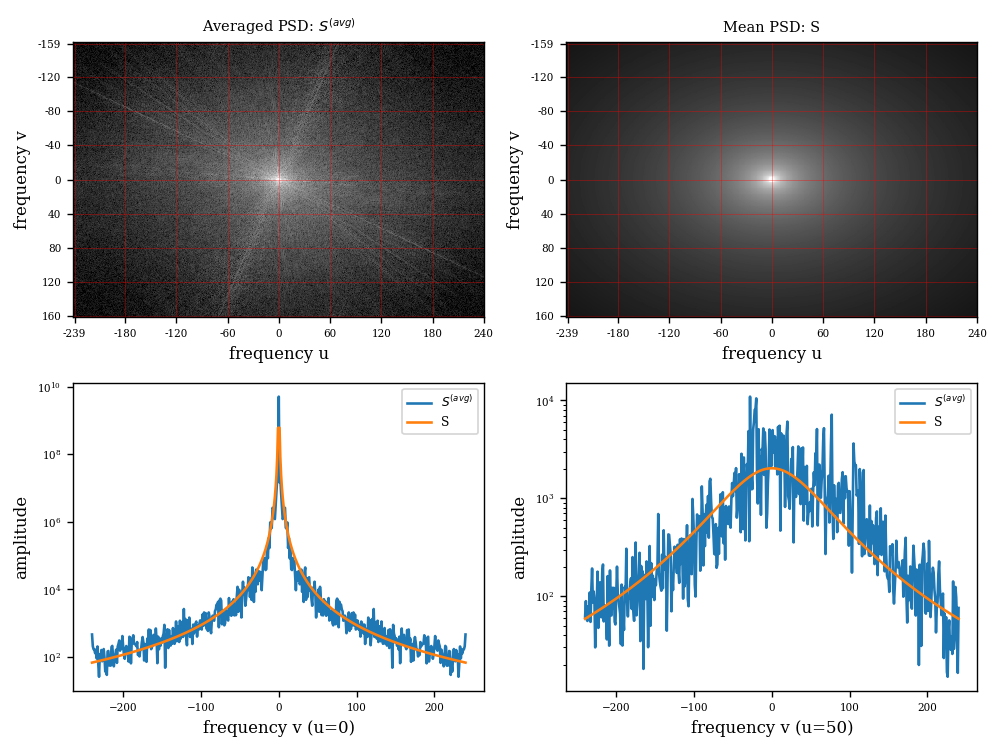

In [26]:
u1 = 0
u2 = 50
x = range(-240,241,1)
s0_avg = npf.fftshift(res[u1])
s0 = npf.fftshift(mpsd[u1])
s50_avg = npf.fftshift(res[u2])
s50 = npf.fftshift(mpsd[u2])
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
im.showfft(res,apply_log=True, vmin=-10, vmax=5)
plt.xlabel("frequency u",fontsize=9.5)
plt.ylabel("frequency v",fontsize=9.5)
plt.title("Averaged PSD: $S^{(avg)}$")
plt.subplot(2,2,2)
im.showfft(mpsd,apply_log=True, vmin=-10, vmax=5)
plt.xlabel("frequency u",fontsize=9.5)
plt.ylabel("frequency v",fontsize=9.5)
plt.title("Mean PSD: S")
plt.subplot(2,2,3)
plt.plot(x,s0_avg)
plt.plot(x,s0)
plt.yscale("log")
plt.xlabel("frequency v (u=0)",fontsize=9.5)
plt.ylabel("amplitude",fontsize=9.5)
plt.legend(["$S^{(avg)}$","S"])
plt.subplot(2,2,4)
plt.plot(x,s50_avg)
plt.plot(x,s50)
plt.yscale("log")
plt.xlabel("frequency v (u=50)",fontsize=9.5)
plt.ylabel("amplitude",fontsize=9.5)
plt.legend(["$S^{(avg)}$","S"])
plt.show()

Looks virtually identical to what was expected, showing the approximation is fairly accurate and the derivations are correct.

### 1.2 Part II (Wiener deconvolution)

### 8

<IPython.core.display.Javascript object>


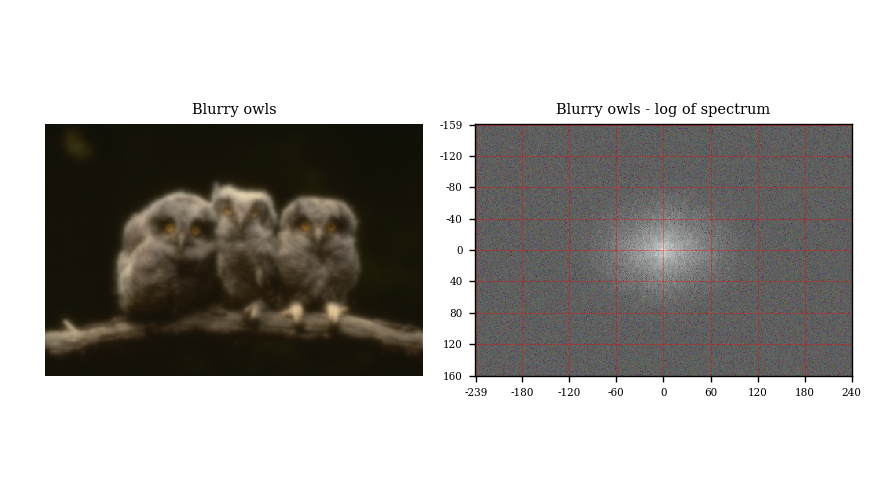

In [42]:
y = plt.imread('assets/owls_blur.png')
fig, axes = plt.subplots(ncols=2, figsize=(7,4))
im.show(y, ax=axes[0])
axes[0].set_title('Blurry owls')
im.showfft(y, ax=axes[1], apply_fft=True,apply_log = True)
axes[1].set_title('Blurry owls - log of spectrum')
fig.show()

### 9

In [70]:
tau = 2
nu = im.kernel('exponential',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)

### 10

In [71]:
def deconvolve_naive(y, lbd, return_transfer=False):
    hhat = np.conj(lbd)/(lbd*np.conj(lbd))
    xdec = np.expand_dims(hhat,axis=2)*npf.fft2(y, axes=(0,1))
    xdec = np.real(npf.ifft2(xdec, axes=(0,1)))
    if return_transfer:
        return xdec, hhat
    else:
        return xdec

<IPython.core.display.Javascript object>


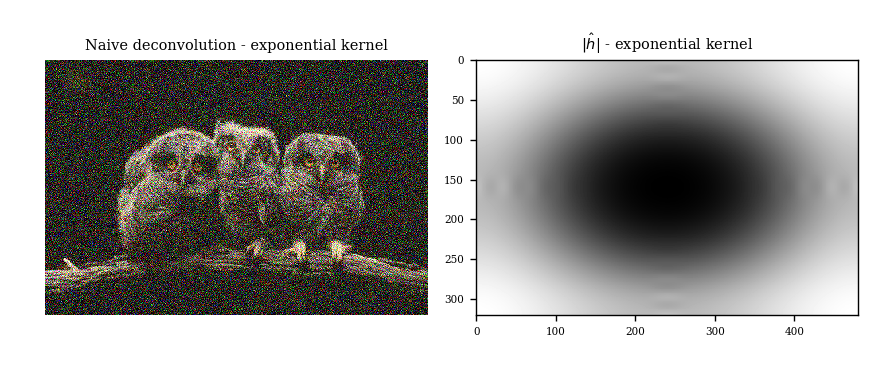

Exponential kernel condition number =  121.63983416309874


In [72]:
xdec_n_exp, hhat_n_exp = deconvolve_naive(y, lbd, True)
cond_num_exp = np.max(np.abs(hhat_n_exp))/np.min(np.abs(hhat_n_exp))
h_hat_mod_exp = npf.fftshift(np.abs(hhat_n_exp))

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
im.show(xdec_n_exp)
plt.title("Naive deconvolution - exponential kernel")
plt.subplot(1,2,2)
plt.imshow(h_hat_mod_exp)
plt.title("$|\hath$| - exponential kernel")
plt.show()

print("Exponential kernel condition number = ",cond_num_exp)

Condition number is pretty high, showing also that this is a fairly poor result, doesn't take into account the noise and values close to 0. Still will be not as bad as for the next 2 kernels, but this shows the weaknesses of the naive deconvolution.

### 11

<IPython.core.display.Javascript object>


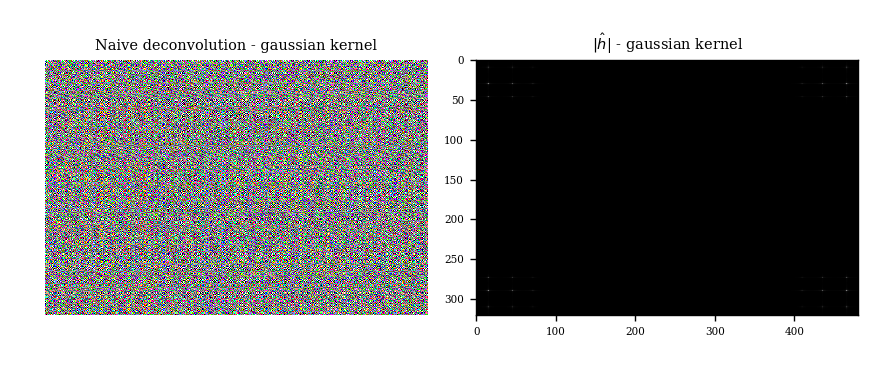

Gaussian kernel condition number =  265174636973.14548


In [74]:
y = plt.imread('assets/owls_blur.png')
nu = im.kernel('gaussian',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)
xdec_n_gaus, hhat_n_gaus = deconvolve_naive(y, lbd, True)
cond_num_gaus = np.max(np.abs(hhat_n_gaus))/np.min(np.abs(hhat_n_gaus))
h_hat_mod_gaus = npf.fftshift(np.abs(hhat_n_gaus))

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
im.show(xdec_n_gaus)
plt.title("Naive deconvolution - gaussian kernel")
plt.subplot(1,2,2)
plt.imshow(h_hat_mod_gaus)
plt.title("$|\hath$| - gaussian kernel")
plt.show()

print("Gaussian kernel condition number = ",cond_num_gaus)

<IPython.core.display.Javascript object>


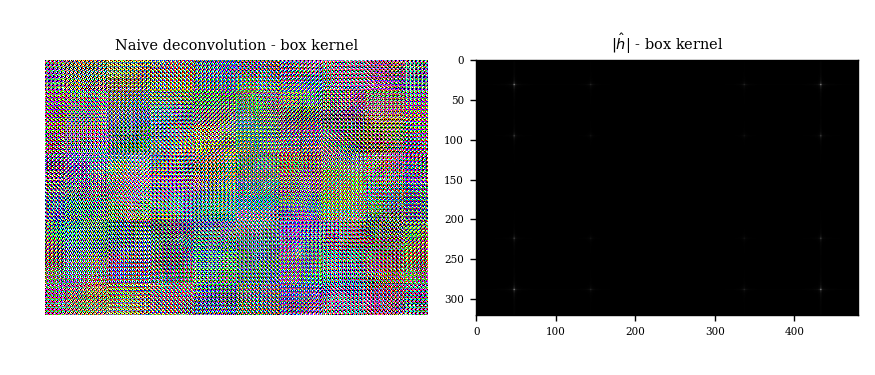

box kernel condition number =  134518.93227054158


In [75]:
nu = im.kernel('box',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)
xdec_n_box, hhat_n_box = deconvolve_naive(y, lbd, True)
cond_num_box = np.max(np.abs(hhat_n_box))/np.min(np.abs(hhat_n_box))
h_hat_mod_box = npf.fftshift(np.abs(hhat_n_box))

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
im.show(xdec_n_box)
plt.title("Naive deconvolution - box kernel")
plt.subplot(1,2,2)
plt.imshow(h_hat_mod_box)
plt.title("$|\hath$| - box kernel")
plt.show()

print("box kernel condition number = ",cond_num_box)

For the exponential kernel, the condition number is ~121.63, while for the box and gaussian kernels the condition number is orders of magnitude higher. This is the meaning of condition number, since higher number corresponds to more difficult inversion. The interpretation is that deconvolving the blurry image with a different type of filter than the one it was originally convolved with yields bad results and a large condition number accordingly.
Also note that the images for $|\hat{h}|$ are all black because of plt.imshow, using im.show would show them as all white since the values are extremely high. This is because we are dividing by numbers close to 0 and not accounting for that, also visible in the deconvolution which is terrible since we are doing that, and also not accounting for noise.

### 12

When $\sigma \rightarrow \infty$, the denominator goes to infinity and so $\hat{h}_{u,v} \rightarrow 0.$, a constant (black) image. This makes sense, since the noise is so large there can be no reconstuction.

When $\sigma \rightarrow 0, \hat{h}_{u,v} \rightarrow \frac{\lambda_{u,v}^*}{|\lambda_{u,v}|^2}$ or equivalently $\frac{1}{\lambda_{u,v}},$ i.e. the wiener deconvolution goes to the same solution as the naive deconvolution since there is no noise.

### 13

In [65]:
def deconvolve_wiener(x, lbd, sig, mpsd, return_transfer=False):
    n1, n2 = mpsd.shape[0:2]
    hhat = np.conj(lbd)/((lbd*np.conj(lbd))+n1*n2*sig**2/mpsd)
    xdec = np.expand_dims(hhat,axis=2)*npf.fft2(y, axes=(0,1))
    xdec = np.real(npf.ifft2(xdec, axes=(0,1)))
    if return_transfer:
        return xdec, hhat
    else:
        return xdec

<IPython.core.display.Javascript object>


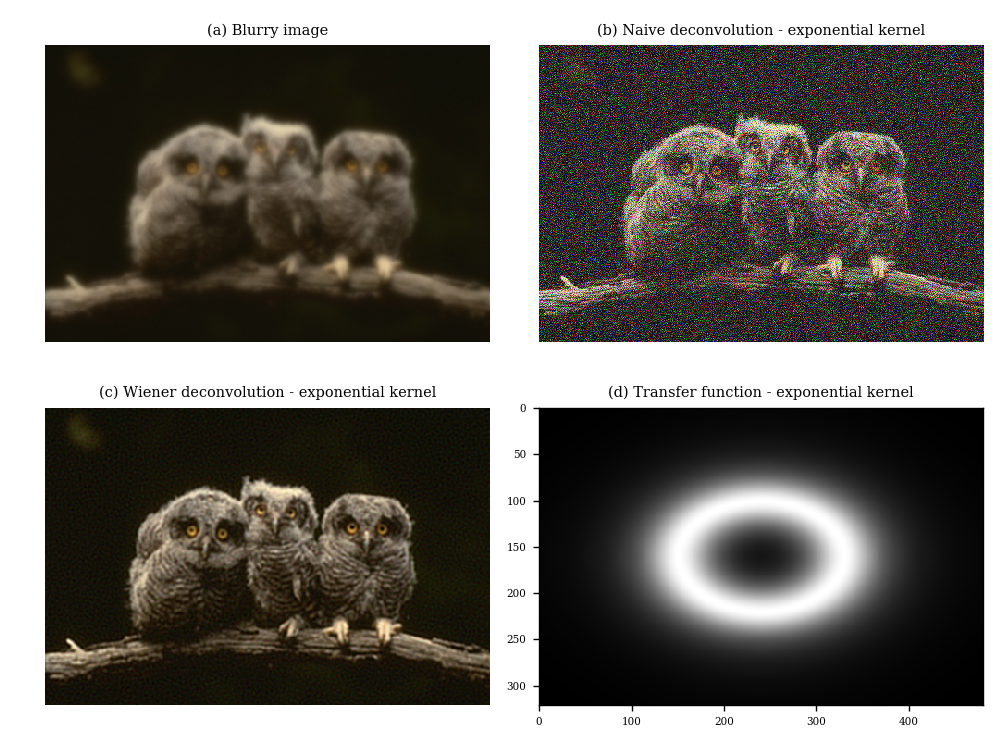

In [59]:
nu = im.kernel('exponential',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)
sig = 1/255
xdec_n_exp_W, hhat_n_exp_W = deconvolve_wiener(y, lbd,sig,mpsd, True)
h_hat_mod_exp_W = npf.fftshift(np.abs(hhat_n_exp_W))

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
im.show(y)
plt.title("(a) Blurry image")

plt.subplot(2,2,2)
im.show(xdec_n_exp)
plt.title("(b) Naive deconvolution - exponential kernel")

plt.subplot(2,2,3)
im.show(xdec_n_exp_W)
plt.title("(c) Wiener deconvolution - exponential kernel")

plt.subplot(2,2,4)
plt.imshow(h_hat_mod_exp_W)
plt.title("(d) Transfer function - exponential kernel")
plt.show()

Looks as expected, wiener deconvolution far better than the naive deconvolution taking into account noise.

### 14

Wiener deconvolution attemps to deblur images in the presence of noise, ie reverse the effect of the convolution (blur) and denoise as well.

### 15

<IPython.core.display.Javascript object>


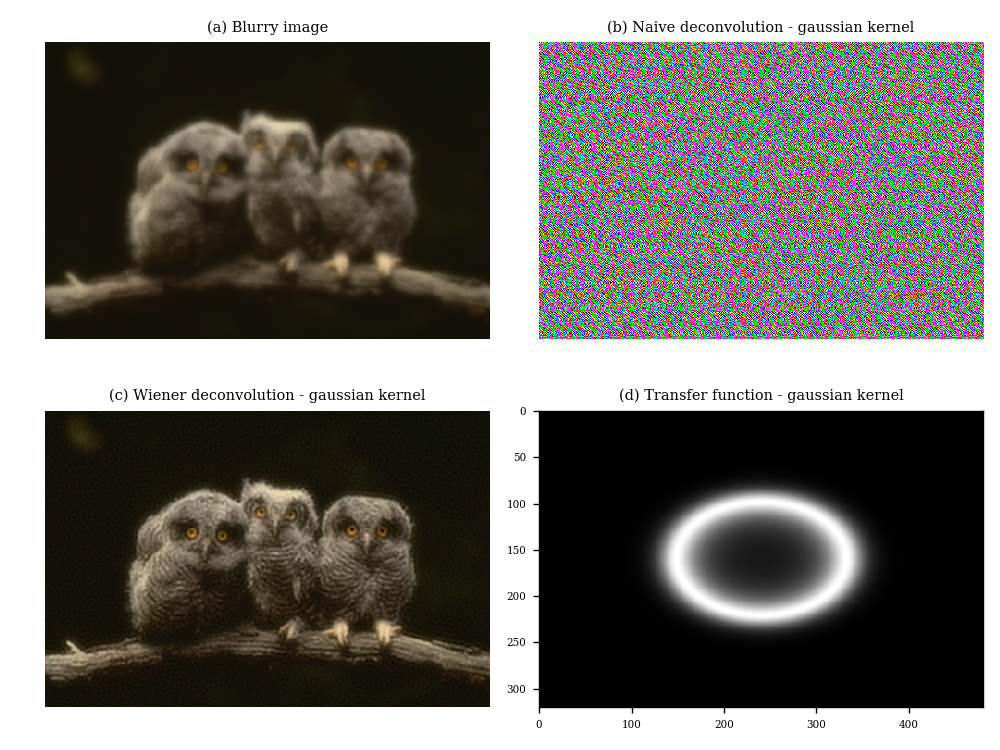

In [63]:
nu = im.kernel('gaussian',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)
sig = 1/255
xdec_n_gauss_W, hhat_n_gauss_W = deconvolve_wiener(y, lbd,sig,mpsd, True)
h_hat_mod_gauss_W = npf.fftshift(np.abs(hhat_n_gauss_W))

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
im.show(y)
plt.title("(a) Blurry image")

plt.subplot(2,2,2)
im.show(xdec_n_gaus)
plt.title("(b) Naive deconvolution - gaussian kernel")

plt.subplot(2,2,3)
im.show(xdec_n_gauss_W)
plt.title("(c) Wiener deconvolution - gaussian kernel")

plt.subplot(2,2,4)
plt.imshow(h_hat_mod_gauss_W)
plt.title("(d) Transfer function - gaussian kernel")
plt.show()

<IPython.core.display.Javascript object>


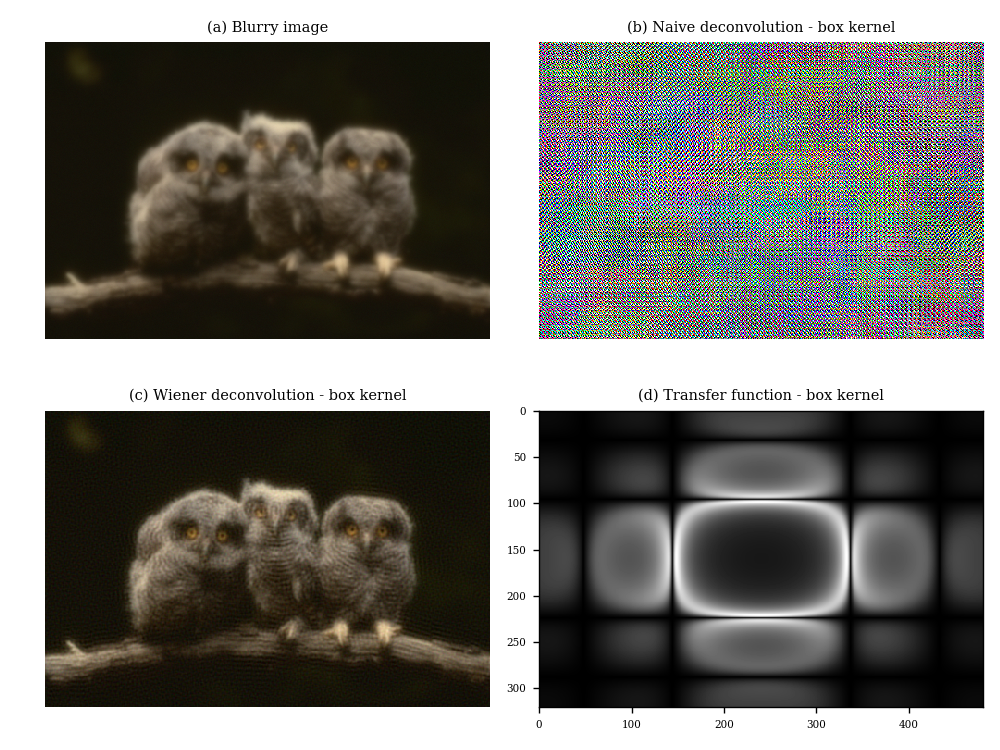

In [64]:
nu = im.kernel('box',tau)
n1,n2 = y.shape[:2]
lbd = im.kernel2fft(nu,n1,n2)
sig = 1/255
xdec_n_box_W, hhat_n_box_W = deconvolve_wiener(y, lbd,sig,mpsd, True)
h_hat_mod_box_W = npf.fftshift(np.abs(hhat_n_box_W))

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
im.show(y)
plt.title("(a) Blurry image")

plt.subplot(2,2,2)
im.show(xdec_n_box)
plt.title("(b) Naive deconvolution - box kernel")

plt.subplot(2,2,3)
im.show(xdec_n_box_W)
plt.title("(c) Wiener deconvolution - box kernel")

plt.subplot(2,2,4)
plt.imshow(h_hat_mod_box_W)
plt.title("(d) Transfer function - box kernel")
plt.show()

We see that the results for wiener deconvolution in general are much better than the naive one since we consider the presence of the noise. In this case, since likely the image was blurred with a exponential kernel, the exponential kernel is the best fit. Also this is evident from the results, as the wiener deconvolution with the gaussian kernel yielded the best results.